In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import tarfile
from pathlib import Path
import seaborn as sns
import shap
from torchvision import transforms as T

In [2]:
# Define the model architecture (exactly as used during training)
class MobileNetMultiRegressor(nn.Module):
    def __init__(self, num_outputs=4):  # You predict 4 values
        super(MobileNetMultiRegressor, self).__init__()
        # Initialize the model with pretrained weights
        self.model = models.mobilenet_v2(pretrained=True)

        # Replace the final layer with a regression head
        in_features = self.model.classifier[1].in_features
        self.model.classifier[1] = nn.Linear(in_features, num_outputs)

    def forward(self, x):
        return self.model(x)

# Initialize the model with 4 outputs
model = MobileNetMultiRegressor(num_outputs=4)

# Load the saved weights from your .pth file
model_path = '/content/best_model_regression.pth'
# Try loading the state dict directly into the underlying model
model.model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


# Set the model to evaluation mode if you're using it for inference
model.eval()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetMultiRegressor(
  (model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kern

In [3]:
# data downloading and dataset utilities

def download_file(url, file_name, cache_dir="data", extract=True, force_download=False, archive_folder=None):
    # Ensure the cache directory exists
    os.makedirs(cache_dir, exist_ok=True)
    file_path = os.path.join(cache_dir, file_name)

    # Download the file
    if not os.path.exists(file_path) or force_download:
      torch.hub.download_url_to_file(url, file_path)
      print(f"File downloaded to: {file_path}")
    else:
      print(f"File already exists at: {file_path}")

    if extract:
      with tarfile.open(file_path, "r:gz") as tar:
          tar.extractall(path=cache_dir)
      print(f"File extracted to: {cache_dir}")
      return Path(cache_dir) / archive_folder if archive_folder is not None else Path(cache_dir)
    elif archive_folder is not None and (Path(cache_dir) / archive_folder).exsists:
      return Path(cache_dir) / archive_folder
    else:
      return Path(cache_dir)

    return Path(file_path)

def load_dataframe(data_dir, dataset):
  data_dir = data_dir / dataset
  df = pd.read_json(data_dir / 'parameters.jsonl', lines=True)
  df['filename'] = df['id'] + '.png'
  #df['ill'] = df['ill'].astype(int).astype(str)

  return df

class ImageDataset(Dataset):
    def __init__(self, df, data_dir, transform=None, target_columns=None):
        self.df = df
        self.data_dir = data_dir
        self.transform = transform
        self.target_columns = target_columns if target_columns is not None else ['spherical', 'ill_spherical', 'bending', 'arm_position']


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.df.iloc[idx]['filename'])
        image = Image.open(img_path).convert('RGB')
        # Load the specified target columns instead of just 'ill'
        targets = self.df.iloc[idx][self.target_columns].values.astype(np.float32)
        targets = torch.tensor(targets)

        if self.transform:
            image = self.transform(image)

        return image, targets

In [4]:
# download datafrom sciebo
data_dir = download_file(url="https://osf.io/download/kexzt/?view_only=adcc520b88cc4ea3b8236c5178ba3ab5",
                         file_name="blockies_datasets.tar.gz",
                         cache_dir='/content/data', # change this if not using Colab
                         extract=True,
                         force_download=False,
                         archive_folder='blockies_datasets')

File already exists at: /content/data/blockies_datasets.tar.gz


/tmp/ipython-input-3849801842.py:17: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=cache_dir)


File extracted to: /content/data


In [5]:
pip install zennit -q

In [6]:
import os
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from zennit.composites import LayerMapComposite, EpsilonPlus
from zennit.attribution import Gradient

In [7]:
from pathlib import Path

# Base directory path
image_dir = Path("/content/data/blockies_datasets/sick_ones_bendbias_v3_2class_variation/test")

# List of filenames
filenames = [
    "9d182975-3c91-49fb-bad8-5857938d8a64.png",
    "691d01dd-9d00-45ac-8c98-6f3b7c2df1c7.png",
    "9f1f8743-1ba3-4d2b-9286-ee77b1df5c29.png",
    "146d4fa4-6deb-4d4b-8076-423458d9ba68.png",
    "d7d45438-e28d-4fd8-a432-71867b2b489c.png",
    "624f5845-af94-4469-86ed-63eb18ecb563.png",
    "7d11e058-79c3-4470-b64a-80ec015ce80c.png",
    "b8c2a998-5bdf-4022-a792-4ad936e379cf.png",
    "2121c74a-38f7-439d-b26c-5d04aa99e2b2.png",
    "dd7f56cd-5a93-47cc-84f0-d4795ac54f66.png",
    "c2c3f450-f479-4e87-9943-8559a06e5512.png",
    "043c3e58-8a31-4326-8e4c-d79dc44e5860.png",
    "363b1a69-bc28-4361-8dd4-be213278d263.png",
    "9a184d92-37dd-4e9f-9bc8-958ae4647ab5.png",
    "ece27a44-06ab-4e2a-b8fa-f5125e114fad.png",
    "4fc2ef4f-03f4-4698-aee0-41aadf982db9.png",
    "5f30712b-a7f4-4ae8-98c5-62833705cf6c.png",
    "279e7a2f-871c-4d0f-adf4-b702a1cba88e.png",
    "e96032a3-c4d0-44ee-8f64-2d28475e8aaf.png",
    "da722cbe-8b96-4894-a48c-f80021b560bd.png",
    "037b6908-0630-40f1-a165-dda61eec4efb.png",
    "170773e0-fbad-425e-91c4-8e8bde1f3c78.png",
    "5059d4ed-8700-4707-a2e8-0b6ec9ed2d37.png",
    "b707e564-ae10-43d5-82b5-e873b7a50725.png",
    "78817294-d529-4367-8b79-1d9f7b0f1648.png",
    "f68911e5-7b55-44ae-a051-31dd290e35c1.png",
    "dfbd70c5-e473-4fb6-9fa7-e7e9223c4645.png",
    "6bc938ad-905e-48f7-a22f-e0d9d0150992.png",
    "17514ba5-facc-4855-90e3-4da478832ca5.png",
    "6ccd4312-d6c6-495d-933b-04e1748f7247.png",
    "5904056d-fb24-4ce4-800a-721b49021b2b.png",
    "927a72db-bc08-4bcf-9ffd-5800da9beede.png",
    "41391444-b316-4561-8638-029165dd8bc7.png",
    "f2ba565f-ff2e-46ad-a5d3-1866f2119239.png",
    "171961c6-e9ad-439f-b004-f901724c900b.png",
    "453a1b63-a7d4-4d8c-8456-b9f4583163ac.png",
    "bb17e814-b00e-48df-ab00-32c5bdac79dc.png",
    "19e2c80f-5bf4-4198-bbb5-dfe3538906f9.png",
    "1779175c-06a1-4b7c-a7f2-0f7126cba921.png"
]

# Convert to full paths
manual_image_paths = [str(image_dir / fname) for fname in filenames]
# Expected output names
expected_output_names = ['spherical', 'ill_spherical', 'bending', 'arm_position']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Remove in-place activations for LRP
def remove_inplace(module):
    for name, child in module.named_children():
        if isinstance(child, (torch.nn.ReLU, torch.nn.ReLU6, torch.nn.Hardtanh)):
            new_child = type(child)(inplace=False)
            setattr(module, name, new_child)
        else:
            remove_inplace(child)

# Image transforms
mean = [0.8068, 0.7830, 0.8005]
std = [0.1093, 0.1136, 0.1029]
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

def denormalize_tensor(t):
    """Denormalize tensor for display."""
    t = t.clone().cpu()
    mean_t = torch.tensor(mean).view(3, 1, 1)
    std_t = torch.tensor(std).view(3, 1, 1)
    return (t * std_t + mean_t).permute(1, 2, 0).numpy()

# Prepare model
remove_inplace(model)
model.to(device).eval()

MobileNetMultiRegressor(
  (model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6()
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6()
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(

In [8]:
!pip install captum -q

In [9]:
import torch
import numpy as np
from zennit.attribution import Gradient
from zennit.composites import EpsilonPlus
from PIL import Image

# Prepare input tensor 'inp'
pil_images = []
for img_path_str in manual_image_paths:
    img = Image.open(img_path_str).convert('RGB')
    pil_images.append(img)

# Apply transformations and stack into a batch tensor
tensors = [transform(img) for img in pil_images]
inp = torch.stack(tensors).to(device)
preds = model(inp)
num_outputs = preds.shape[1]
batch_size = preds.shape[0]

relevance_maps_all = []

# Loop through each regression output
for out_idx in range(num_outputs):

    target_for_attribution = torch.zeros_like(preds, device=inp.device)
    target_for_attribution[:, out_idx] = 1.0 # Standard for LRP attribution to a specific output

    # Compute LRP
    with Gradient(model=model, composite=EpsilonPlus()) as attributor:
        _, relevance = attributor(inp, target_for_attribution)

    # Process and normalize
    rel = relevance.sum(dim=1).detach().cpu().numpy()  # sum channels

    # Handle cases where rel might be all zeros to avoid division by zero
    absmax = np.max(np.abs(rel), axis=(1, 2), keepdims=True)
    # Add a small epsilon to avoid division by zero if absmax is 0
    rel = rel / (absmax + 1e-9)

    relevance_maps_all.append(rel)

print("LRP successfully computed for all outputs!")
pred_np = preds.detach().cpu().numpy()
valid_filenames = [Path(f).name for f in manual_image_paths]
output_names = expected_output_names


LRP successfully computed for all outputs!


/tmp/ipython-input-3154789869.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


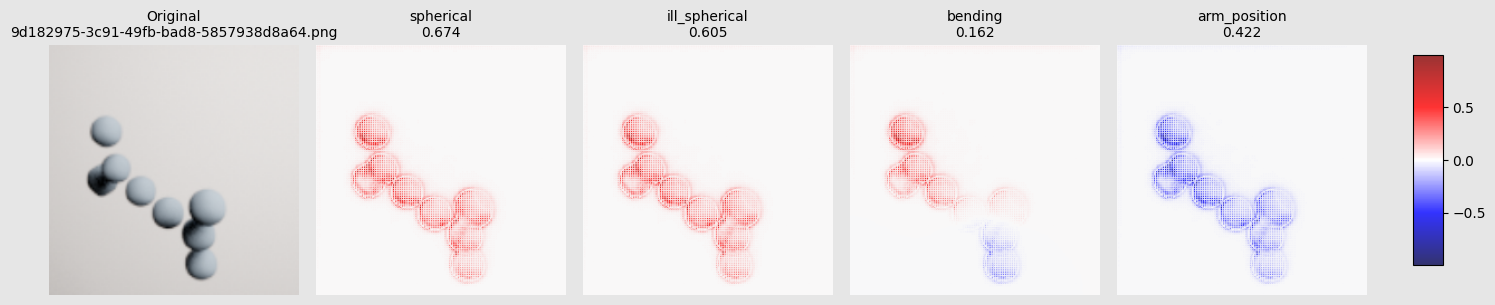

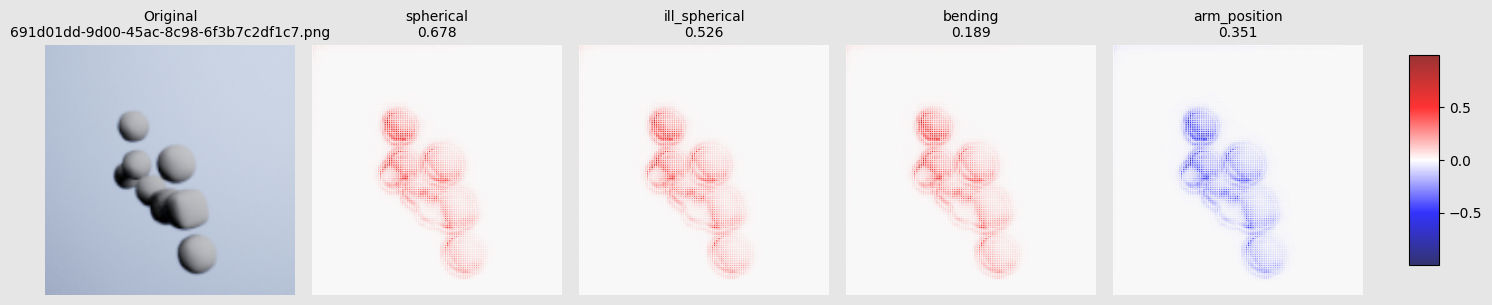

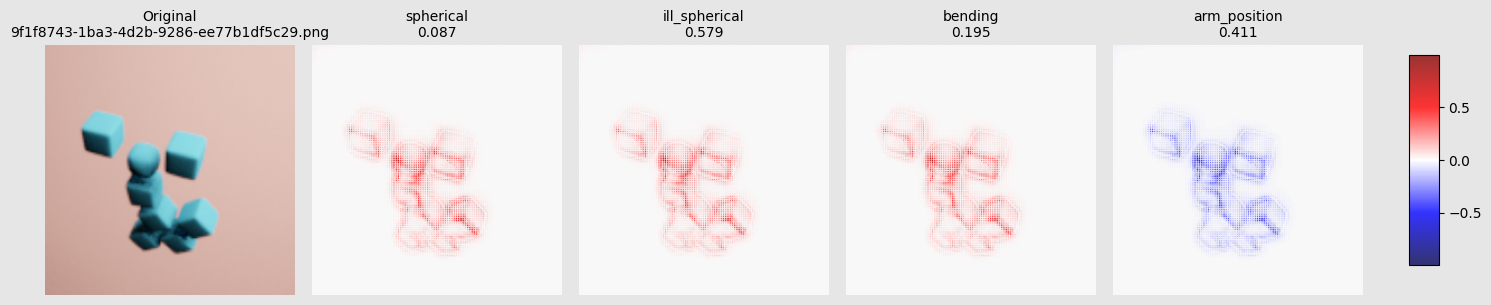

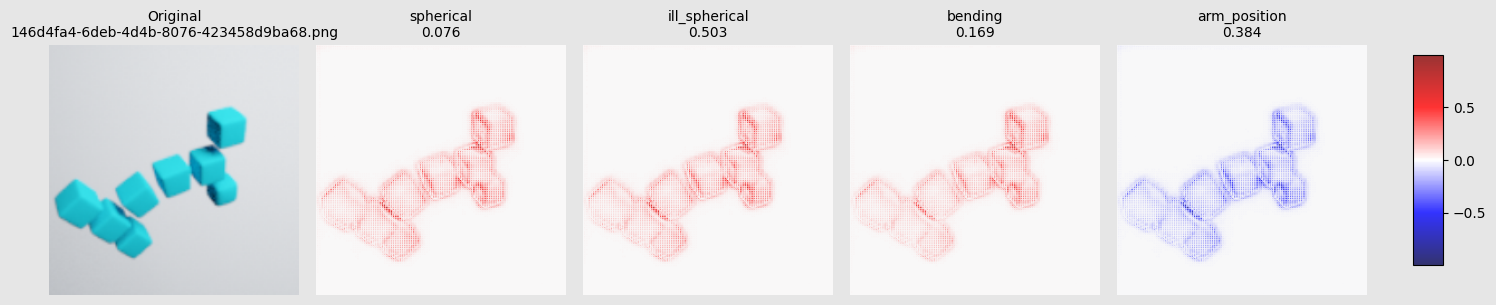

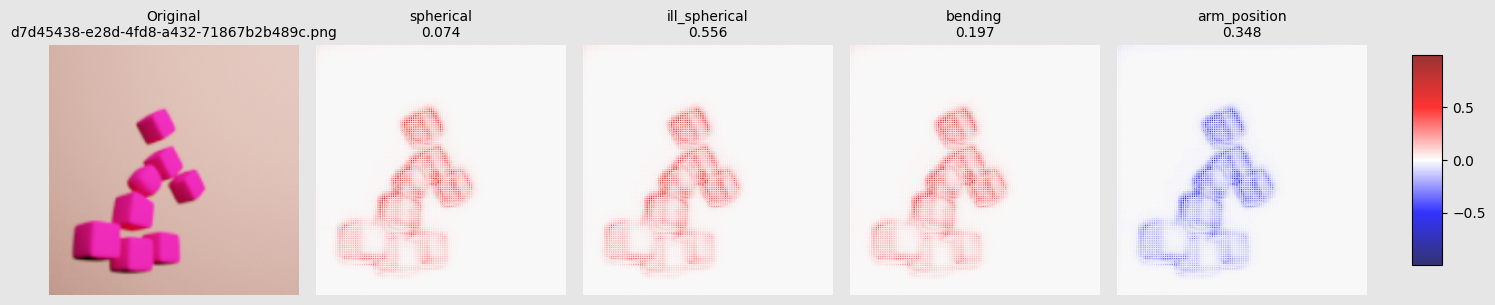

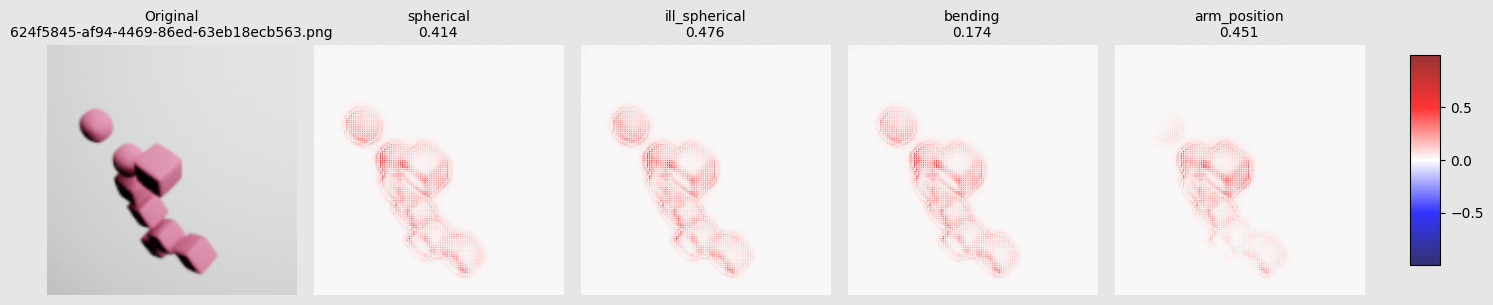

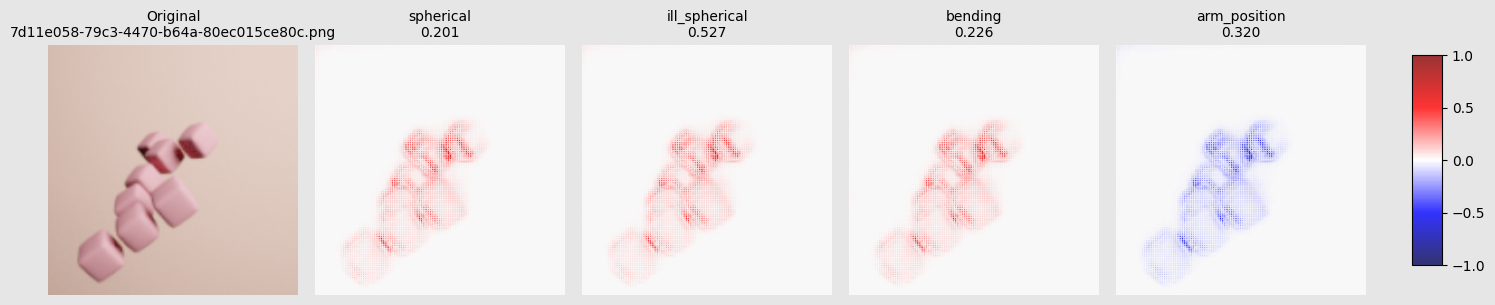

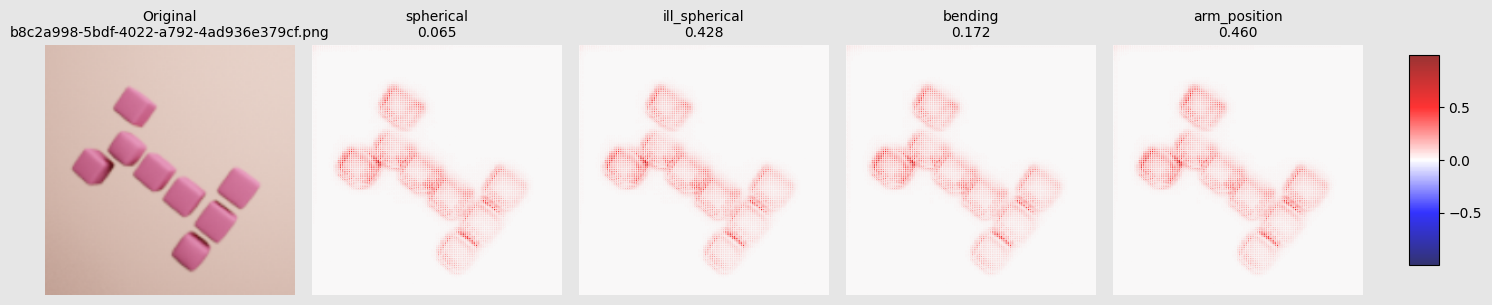

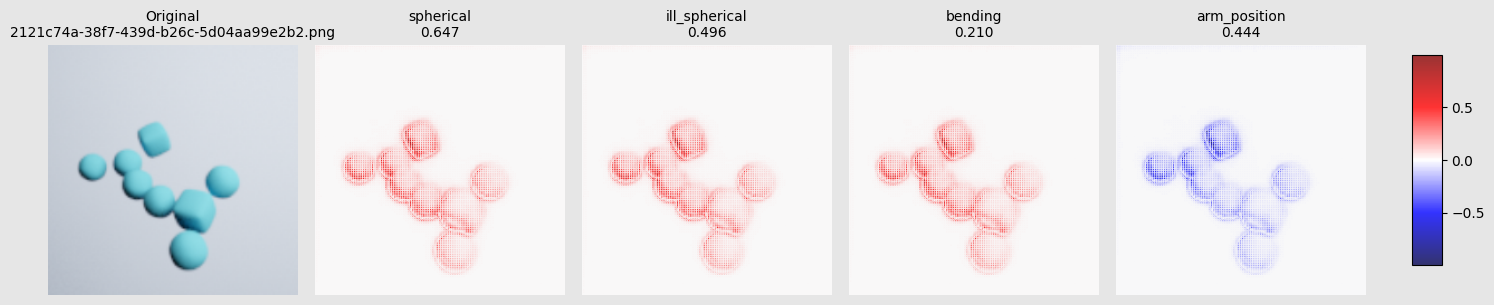

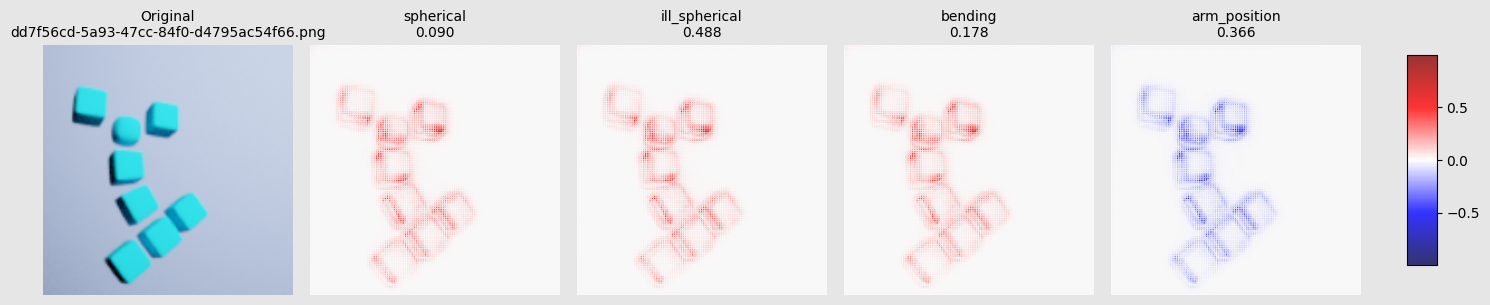

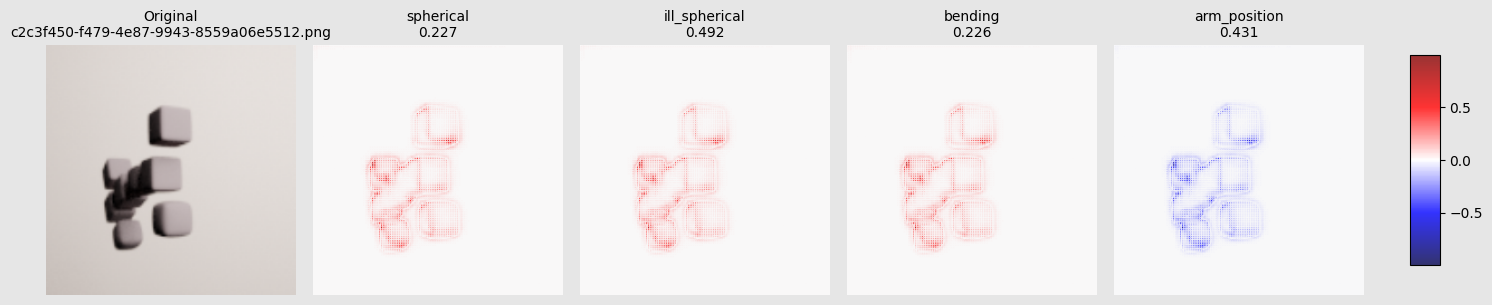

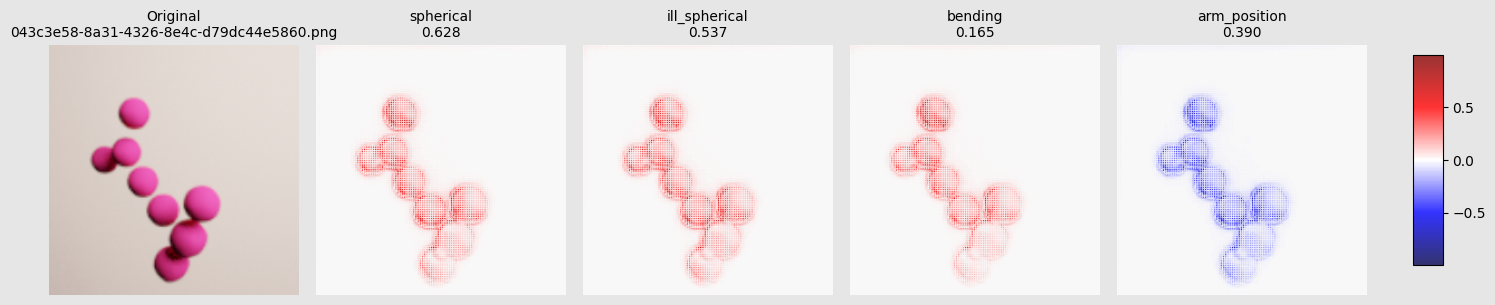

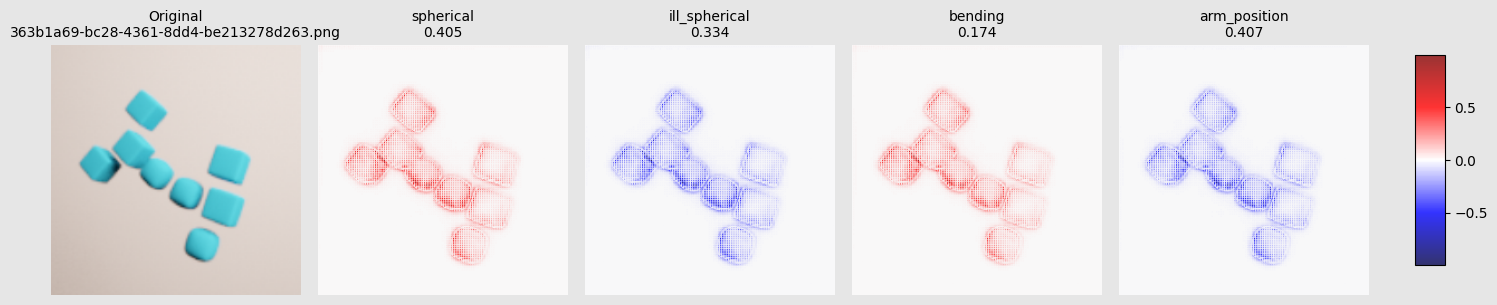

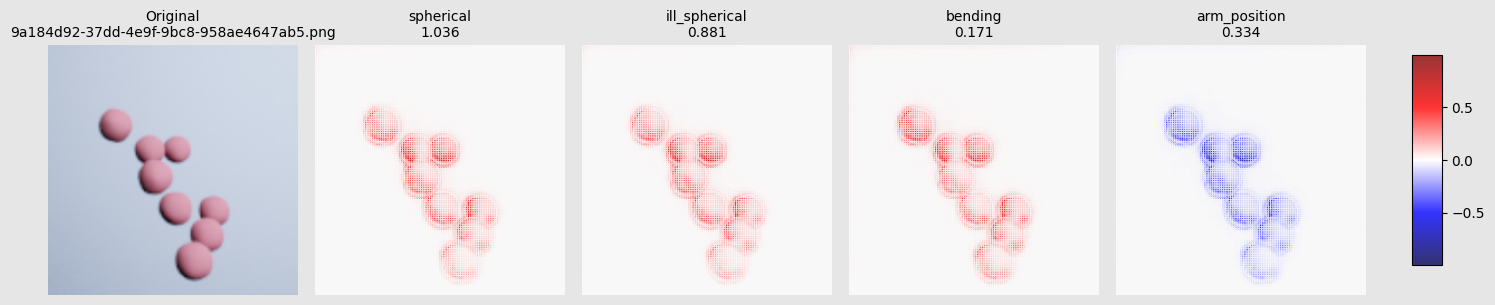

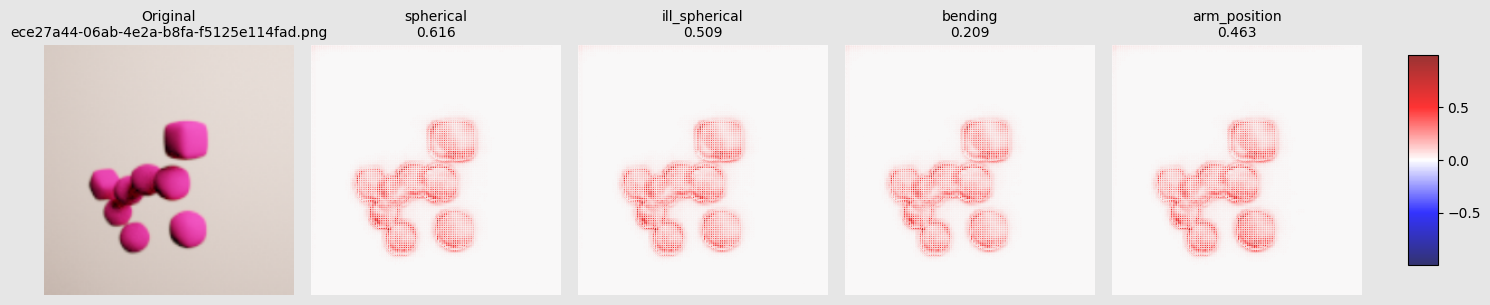

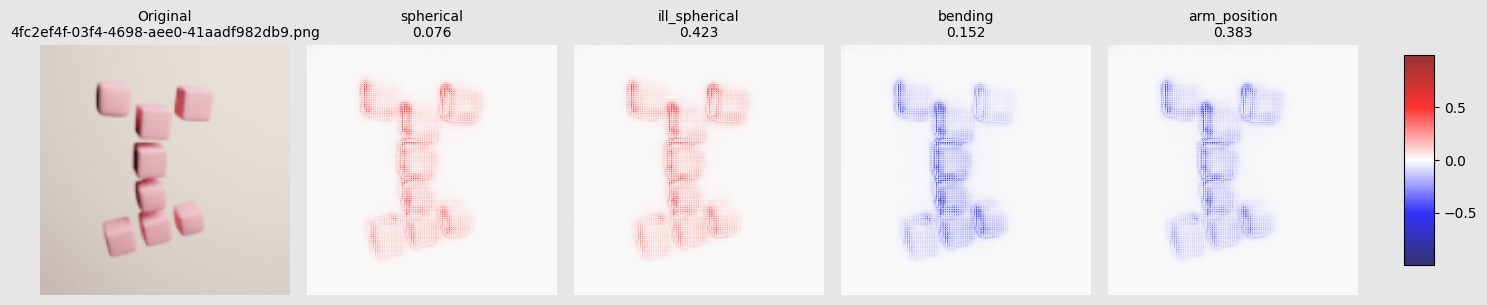

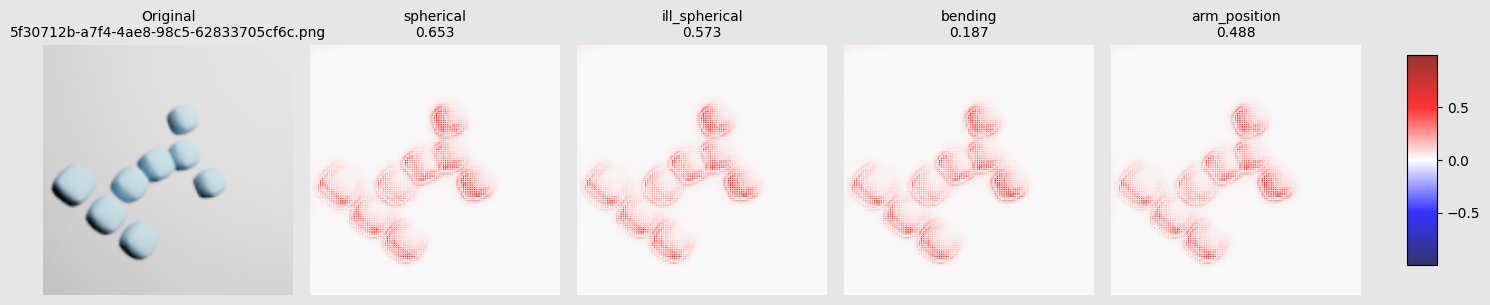

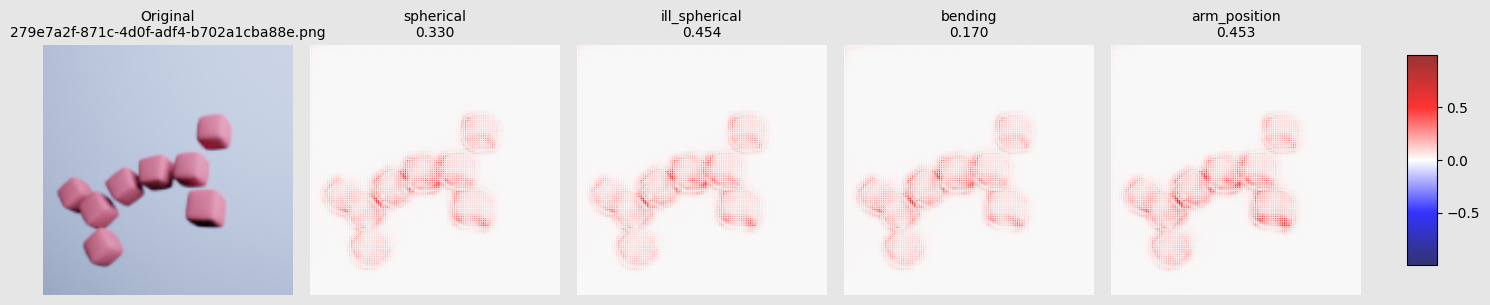

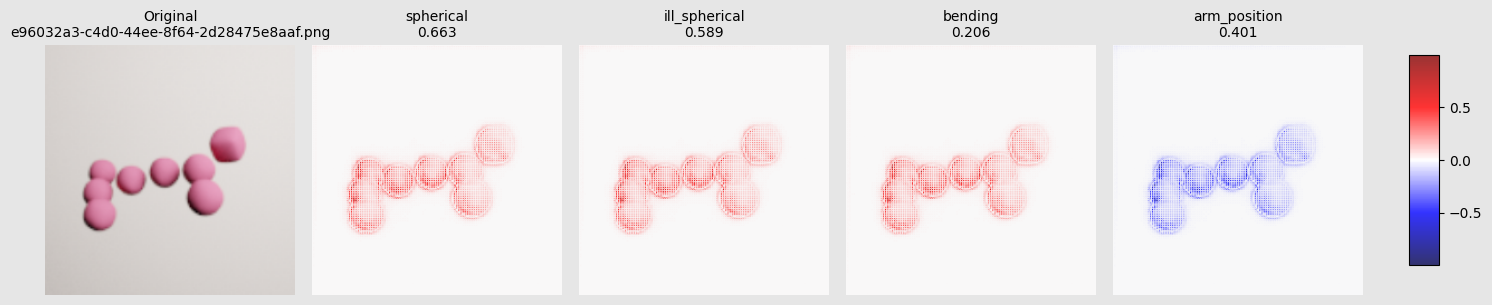

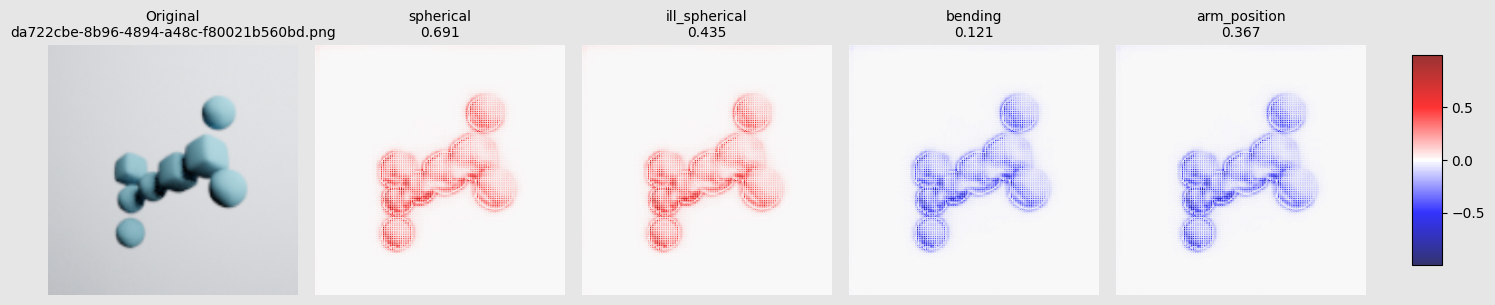

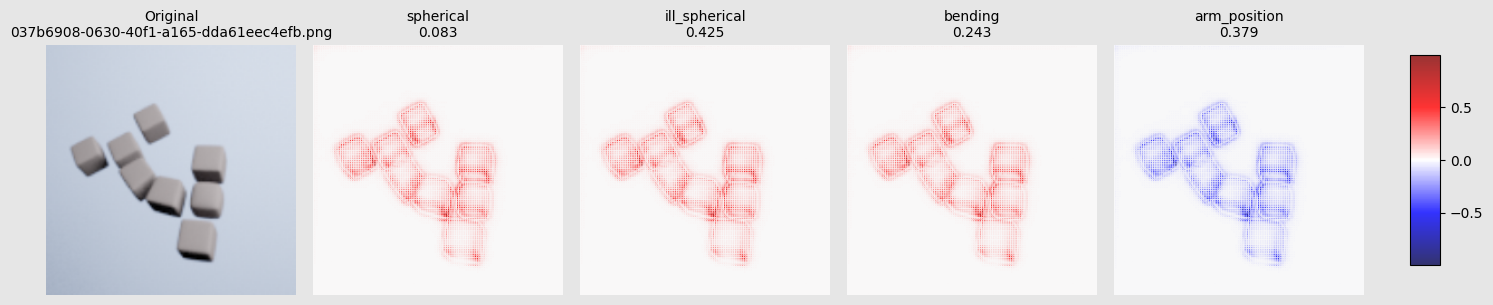

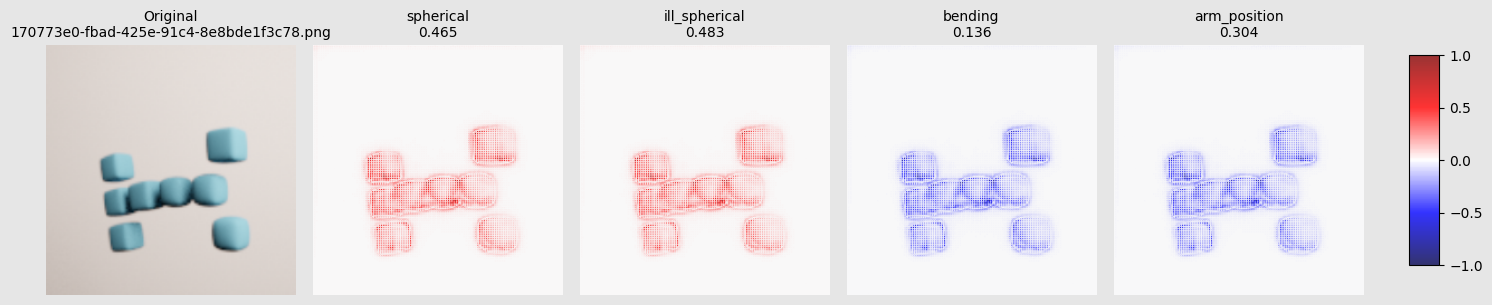

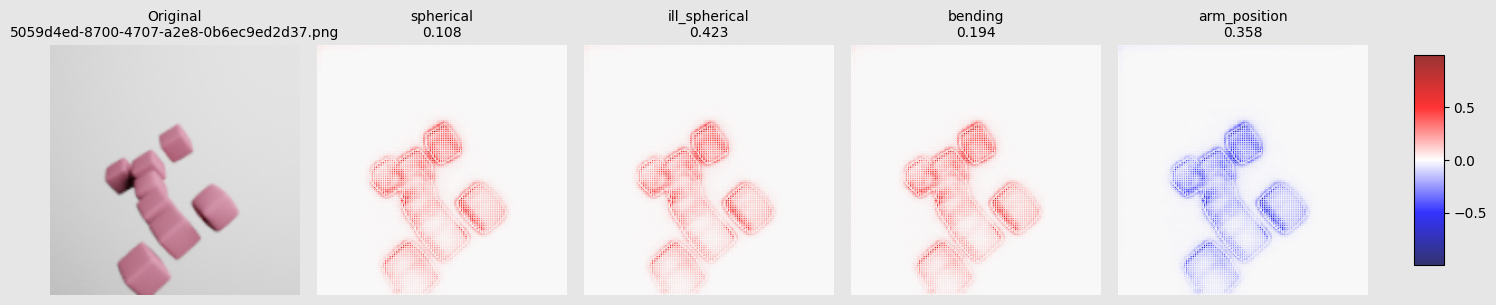

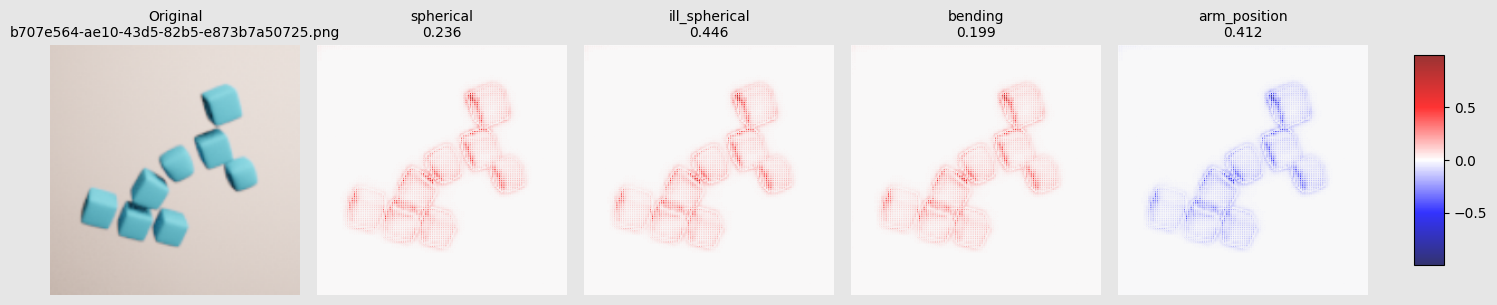

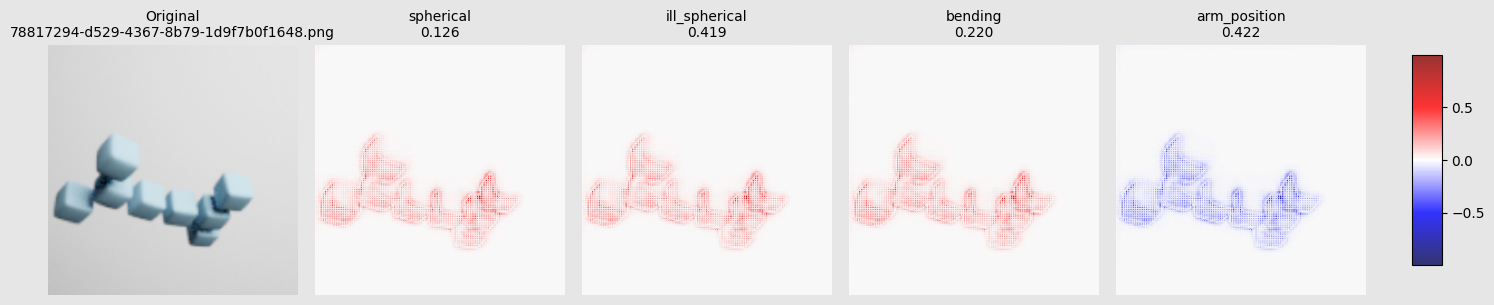

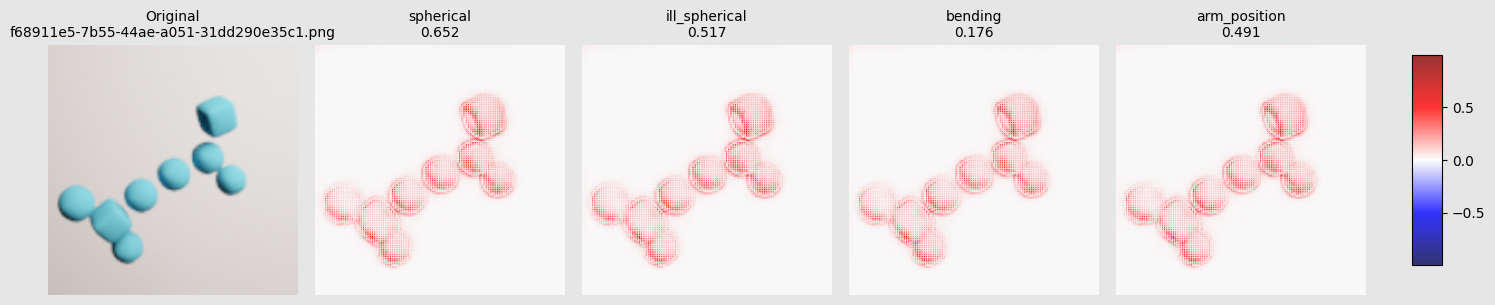

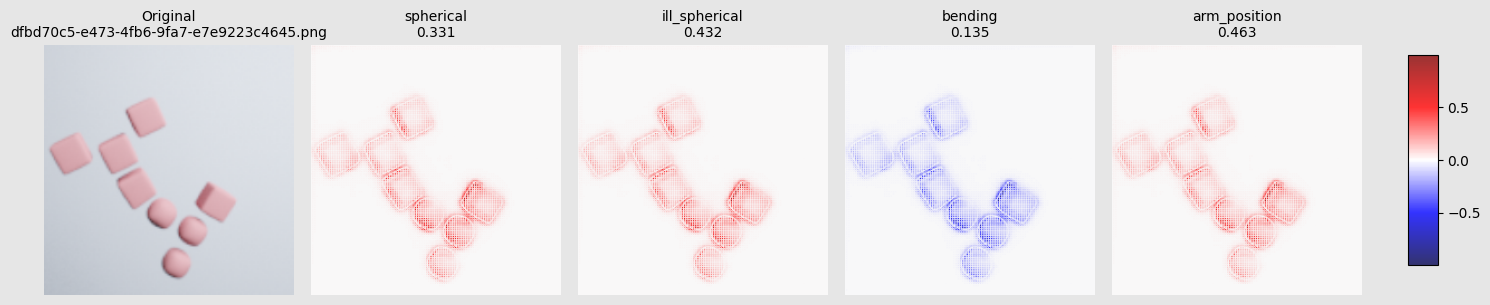

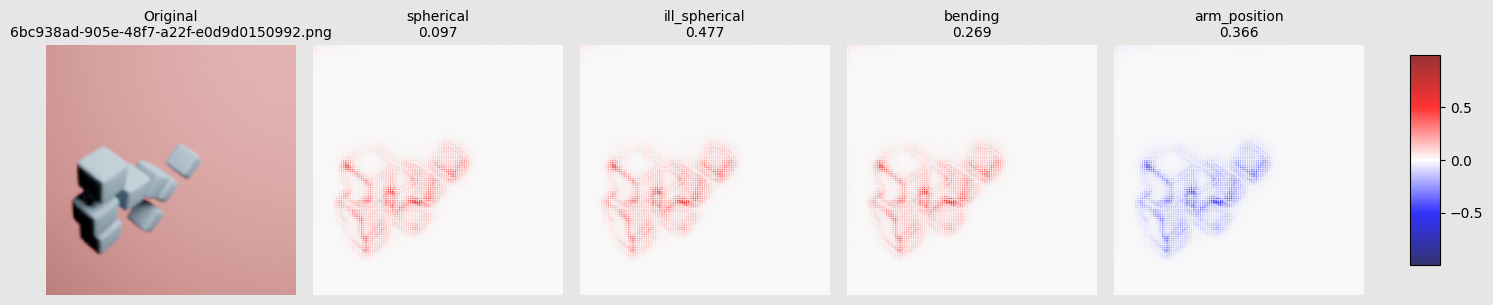

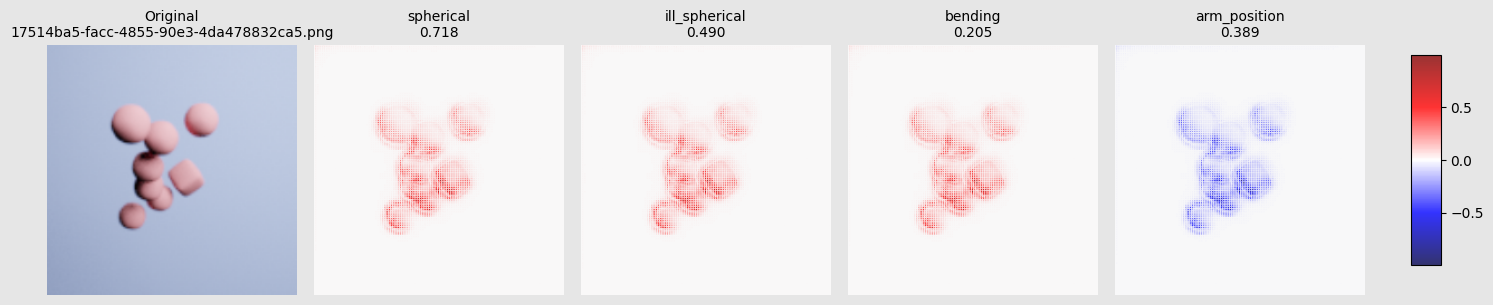

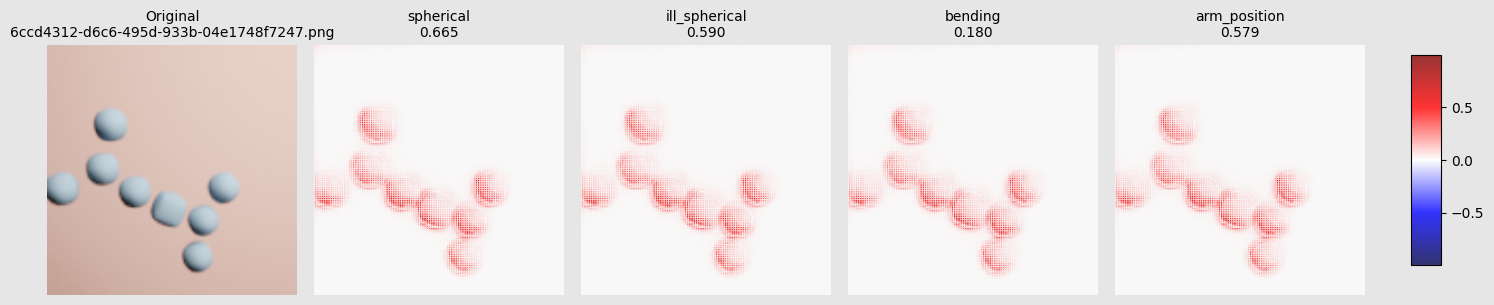

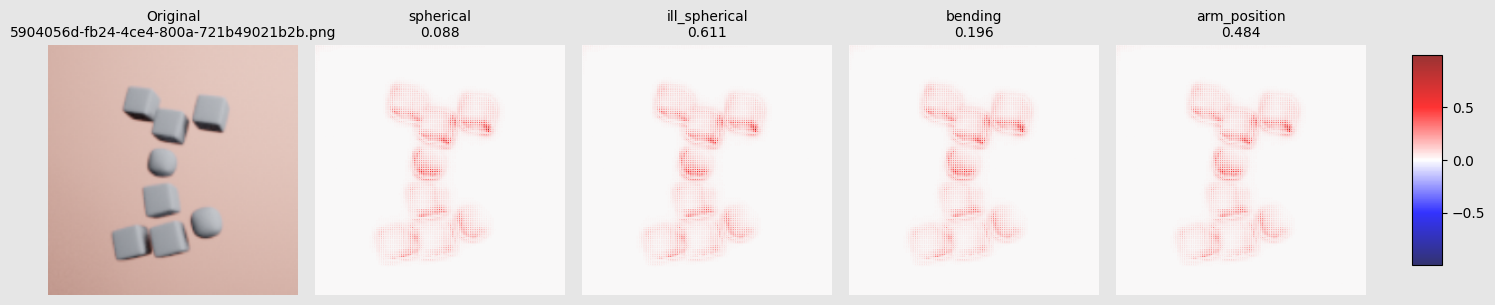

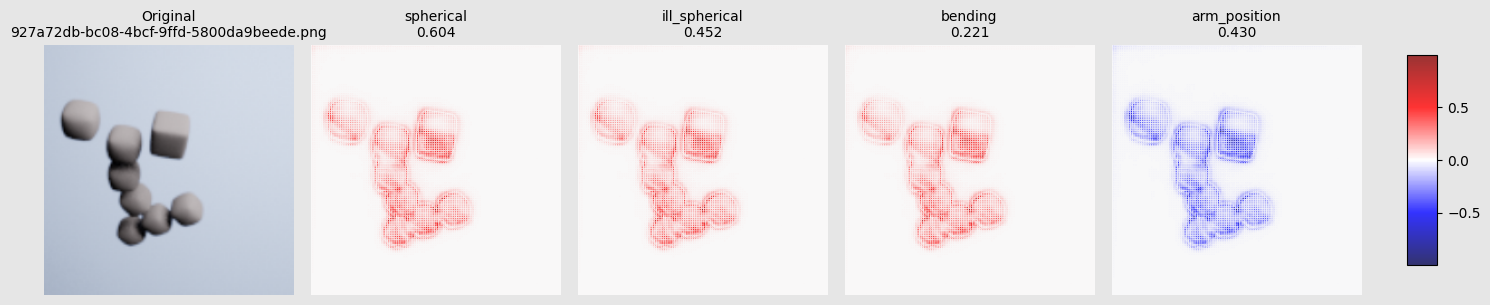

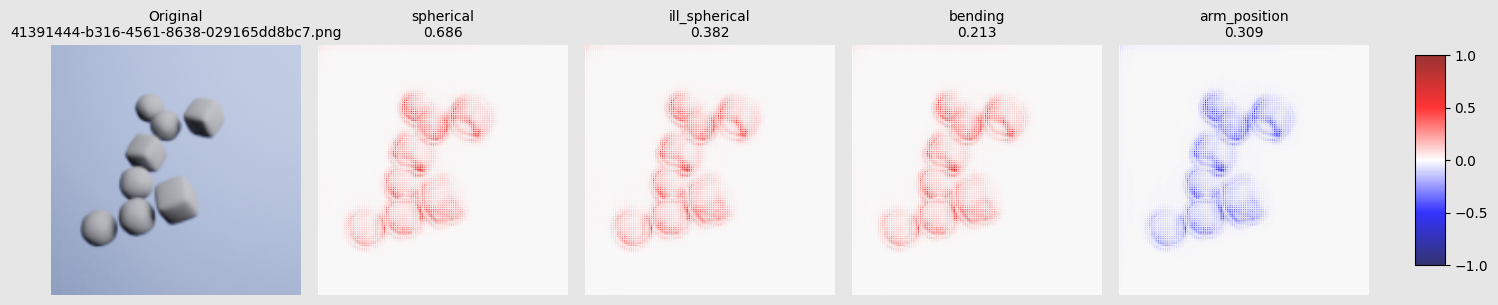

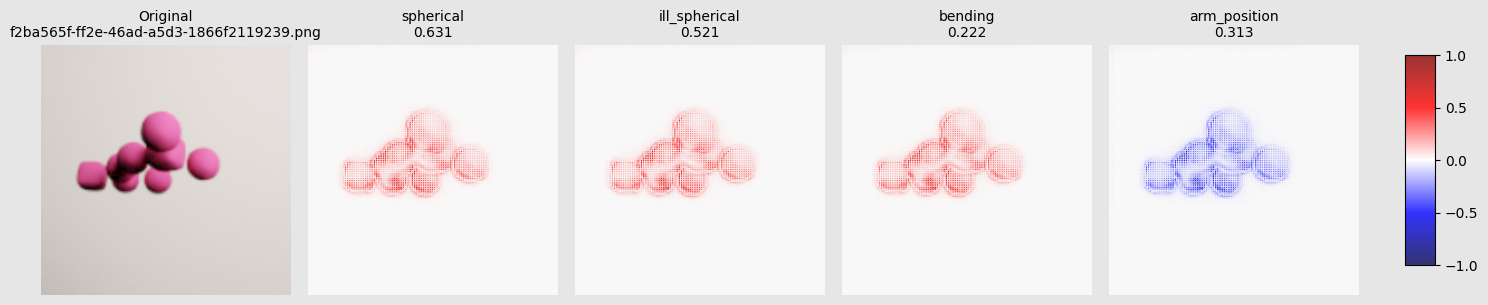

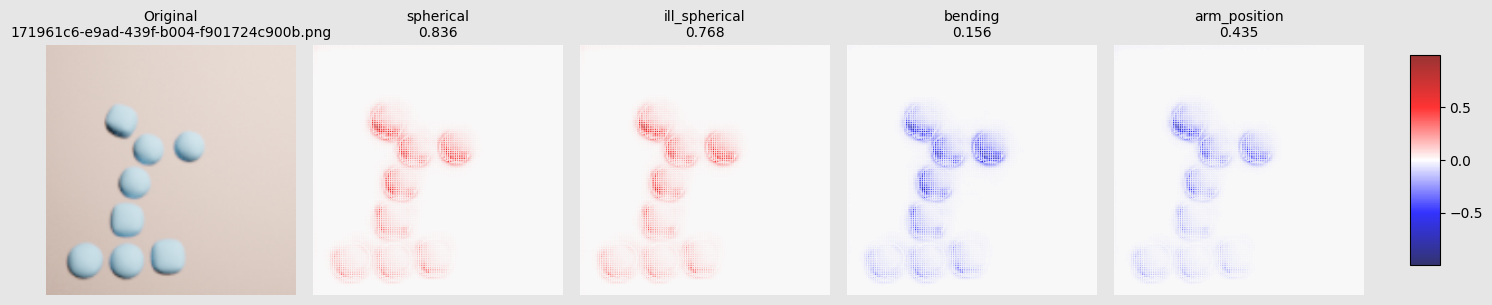

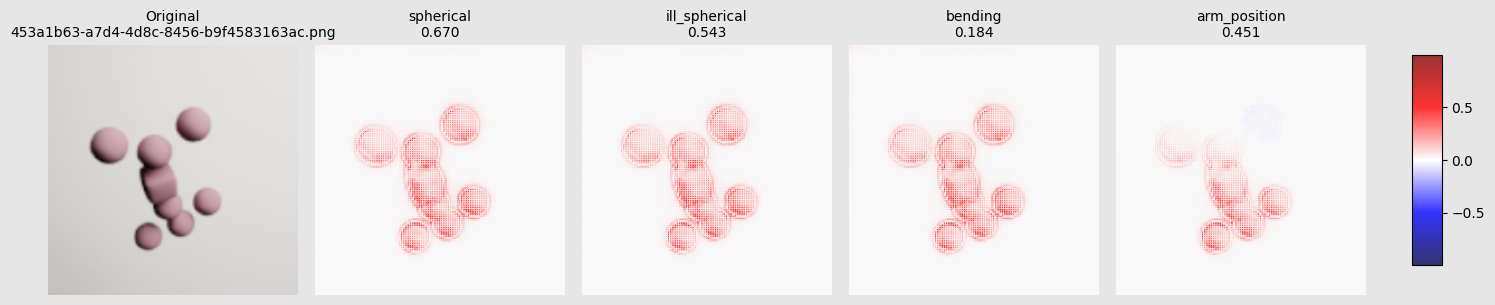

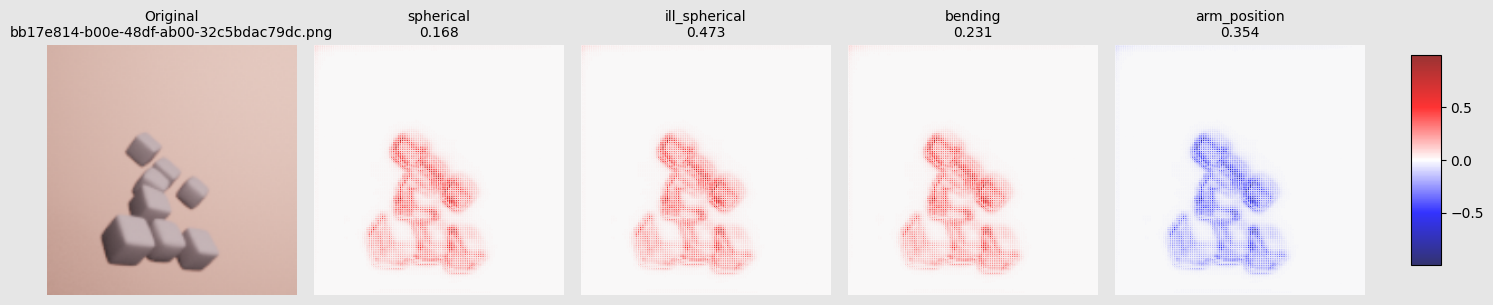

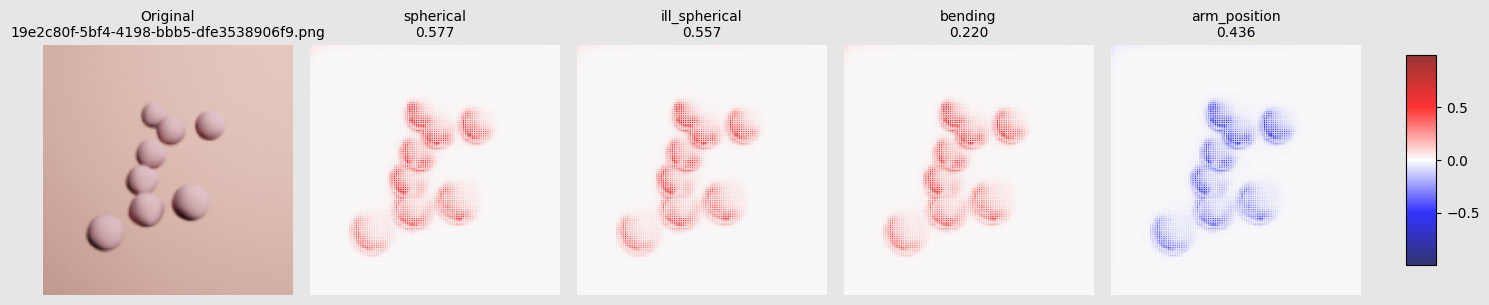

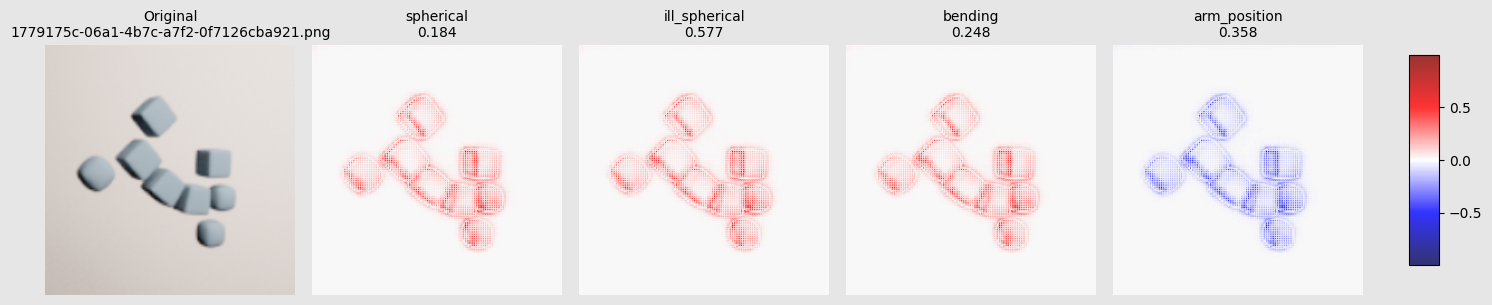

In [14]:
# Visualization
bg_color = [0.9, 0.9, 0.9]  # Light gray background
alpha = 0.8  # Overlay transparency
cmap = 'seismic'  # Blue-White-Red colormap

for i in range(batch_size):
    fname = valid_filenames[i]
    fig = plt.figure(figsize=(3 * (num_outputs + 1), 3), facecolor=bg_color)
    gs = fig.add_gridspec(1, num_outputs + 1)

    # Original image
    ax0 = fig.add_subplot(gs[0])
    orig_img = denormalize_tensor(inp[i])
    ax0.imshow(orig_img)
    ax0.axis('off')
    ax0.set_title(f"Original\n{fname}", fontsize=10)

    # Relevance maps for each output
    for out_idx in range(num_outputs):
        ax = fig.add_subplot(gs[out_idx + 1])
        rel = relevance_maps_all[out_idx][i]

        # Ensure relevance map is a NumPy array and has the correct shape
        rel_np = np.array(rel).squeeze()

        if rel_np.ndim != 2:
            print(f"WARNING: Relevance map for image {i}, output {out_idx} has unexpected shape: {rel_np.shape}")
            continue # Skip plotting this relevance map if shape is wrong

        # Use max absolute value for symmetric vmin/vmax
        vmax = np.abs(rel_np).max()
        vmin = -vmax

        # Directly plot the relevance map on the subplot
        im = ax.imshow(rel_np, cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha) # Use alpha here

        ax.axis('off')
        ax.set_title(f"{output_names[out_idx]}\n{pred_np[i, out_idx]:.3f}", fontsize=10)

    # Colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()